# Task 1
## Part 1
Refs:
https://www.kaggle.com/code/omarghazy56/cats-vs-dogs-pytorch

Dataset: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/code?datasetId=550917&searchQuery=pytorch

*This data set contains two class of images Cats and Dogs. This can be best utilized in a binary classification problem set in computer vision.*

In [1]:
! wget --no-check-certificate \
https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip\
-O ./cats_and_dogs_filtered.zip

--2025-03-18 01:40:16--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 2600:141b:e800:148c::317f, 2600:141b:e800:1483::317f, 23.213.150.23
Connecting to download.microsoft.com (download.microsoft.com)|2600:141b:e800:148c::317f|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>] 786.67M   110MB/s    in 7.2s    

2025-03-18 01:40:23 (110 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [824887076/824887076]



In [ ]:
! unzip cats_and_dogs_filtered.zip

In [3]:
!ls

 cats_and_dogs_filtered.zip   hw5.ipynb  'readme[1].txt'
 CDLA-Permissive-2.0.pdf      PetImages


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


import cv2
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import time
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


## Visilization of Dataset


(375, 500, 3)


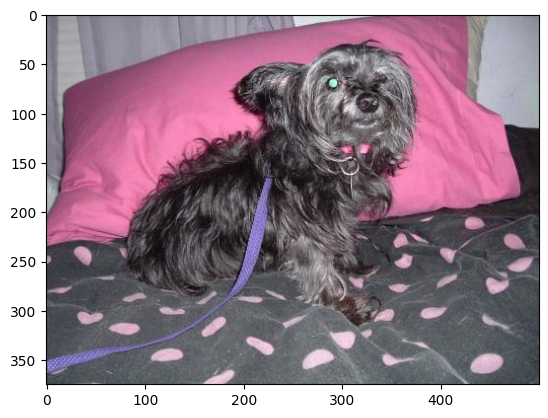

In [2]:
img = plt.imread('./PetImages/Dog/0.jpg')
print(img.shape)
plt.imshow(img);

In [3]:
def make_training_data():

    # Size of the image
    IMG_SIZE = 128

    # Directory location
    CATS = './PetImages/Cat/'
    DOGS = './PetImages/Dog/'

    # Labels for cats and dogs
    LABELS = {CATS:0, DOGS:1}

    # Initializing variables
    training_data = []
    catcount = 0
    dogcount = 0
    for label in LABELS:

        # Looping through each pictures
        for f in tqdm(os.listdir(label)):
            try:
                path = os.path.join(label, f)

                # Reading images and converting to RGB
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                # Resizing images
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                # Getting the training data
                training_data.append([np.array(img), np.eye(2)[LABELS[label]]])

                # Checking distribution of data
                if label == CATS:
                    catcount += 1
                elif label == DOGS:
                    dogcount += 1

            except Exception as e:
                pass

        np.random.shuffle(training_data)

        print("Cats: ", catcount)
        print("Dogs: ", dogcount)
    return training_data


training_data = make_training_data()

100%|██████████| 12501/12501 [00:06<00:00, 1854.83it/s]


Cats:  12476
Dogs:  0


100%|██████████| 12501/12501 [00:07<00:00, 1747.14it/s]

Cats:  12476
Dogs:  12470


In [4]:
# training data preprocessing
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),
    transforms.ToTensor(),
])
# testing data preprocessing
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        self.y = y
        if y is not None:
            self.y = torch.Tensor(y.numpy())
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [5]:
print(training_data[0])
print(torch.Tensor(training_data[0][0]).shape)

[array([[[188, 187, 191],
        [218, 217, 221],
        [215, 214, 218],
        ...,
        [198, 204, 203],
        [202, 208, 207],
        [202, 208, 207]],

       [[187, 186, 190],
        [221, 219, 224],
        [219, 218, 222],
        ...,
        [211, 217, 216],
        [210, 216, 215],
        [210, 216, 215]],

       [[189, 188, 192],
        [223, 222, 226],
        [222, 221, 225],
        ...,
        [209, 215, 214],
        [208, 214, 213],
        [208, 214, 213]],

       ...,

       [[244, 242, 242],
        [179, 177, 177],
        [202, 197, 198],
        ...,
        [ 34,   5,   2],
        [ 38,   5,   1],
        [ 37,   5,   0]],

       [[239, 237, 237],
        [178, 176, 176],
        [200, 195, 196],
        ...,
        [ 50,  27,  21],
        [ 36,   9,   2],
        [ 35,  11,   1]],

       [[245, 242, 243],
        [180, 175, 176],
        [188, 185, 185],
        ...,
        [ 83,  66,  58],
        [ 42,  22,  14],
        [ 36,  17,   7]

In [6]:
# Creating a tensor from a list of numpy.ndarrays is extremely slow
# so converting it first to np.array
# for i in training_data:
#   print(i[0].shape)
print(training_data[1848][0].shape)
X_np = np.array([i[0] for i in training_data])

print(X_np.shape)
# Create a tensor from the NumPy array
X = torch.from_numpy(X_np).view(-1, 128, 128, 3)
# print(X.shape)
X = torch.permute(X, (0, 3, 1, 2))
X = X.float()
print(X.shape)

#Scaling the features
# X = X / 255.0
#X = (( np.transpose(X, axis=(0, 3, 2, 1))- X.mean((2,3))) / np.transpose(X.std((2,3)), axis=(0, 3, 2, 1)))
#Compute mean and standard deviation along specified axes
mean = torch.mean(X, dim=(0, 2, 3))
std = torch.std(X, dim=(0, 2, 3))

# Normalize the tensor using computed mean and standard deviation
X = (X - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)

# Getting the target
y = torch.Tensor([i[1] for i in training_data])

(128, 128, 3)
(24946, 128, 128, 3)
torch.Size([24946, 3, 128, 128])


/tmp/ipykernel_2359696/967254486.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  y = torch.Tensor([i[1] for i in training_data])


In [7]:
print(X.shape)
print(y.shape)

torch.Size([24946, 3, 128, 128])
torch.Size([24946, 2])


In [8]:
y_label = []
real = torch.argmax(y)
for i in range(len(y)):
    real = torch.argmax(y[i])
    y_label.append(real.item())
y_label = torch.Tensor(y_label)
print('Cats :',(y_label == 0.).sum().item())
print('Dogs :',y_label.sum().item())

Cats : 12476
Dogs : 12470.0


In [9]:
#split train and test
val = int(len(X)*0.3)
train_x = X[:-val]
train_y = y_label[:-val]
val_x = X[-val:]
val_y = y_label[-val:]
print("Train size :",len(train_x))
print("Validation size :",len(val_x))

Train size : 17463
Validation size : 7483


In [10]:
batch_size=64

train_set = ImgDataset(train_x,train_y,train_transform)
test_set = ImgDataset(val_x,val_y,test_transform)

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size= batch_size, shuffle=False)


In [11]:
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
# torch.nn.MaxPool2d(kernel_size, stride, padding)
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input [1, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,2)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [12]:

#setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = Classifier().to(device)
cirection = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

cuda


In [13]:
#train
epochs = 10
v_loss = []
t_loss = []
t_acc = []
v_acc = []

for epoch in range(epochs):
    epoch_start_time = time.time()
    train_acc =0.0
    val_acc =0.0
    train_loss = 0.0
    val_loss =0.0
    model.train()
    for i,data in enumerate(train_loader):
        optimizer.zero_grad()
        x,y = data[0].to(device),data[1].to(device)
        # print(x.shape)
        y_pred = model(x)
        loss = cirection(y_pred,y.long())
        loss.backward()
        optimizer.step()
        train_acc +=np.sum(np.argmax(y_pred.cpu().data.numpy(),axis=1)== y.cpu().numpy())
        train_loss +=loss.item()

    model.eval()
    with torch.no_grad():
        for i,data in enumerate(test_loader):
            valx ,valy = data[0].to(device),data[1].to(device)
            val_pred = model(valx)
            batch_loss = cirection(val_pred,valy.long())
            val_acc +=np.sum(np.argmax(val_pred.cpu().data.numpy(),axis=1)== valy.cpu().numpy())
            val_loss +=batch_loss.item()
        t_loss.append(train_loss / train_set.__len__())
        v_loss.append(val_loss / test_set.__len__())
        t_acc.append(train_acc / train_set.__len__())
        v_acc.append(val_acc / test_set.__len__())
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, epochs, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/test_set.__len__(), val_loss/test_set.__len__()))


[001/010] 15.04 sec(s) Train Acc: 0.643876 Loss: 0.009921 | Val Acc: 0.635708 loss: 0.010468
[002/010] 14.70 sec(s) Train Acc: 0.684533 Loss: 0.009066 | Val Acc: 0.609916 loss: 0.012786
[003/010] 14.42 sec(s) Train Acc: 0.708985 Loss: 0.008648 | Val Acc: 0.673393 loss: 0.009326
[004/010] 14.25 sec(s) Train Acc: 0.737159 Loss: 0.008149 | Val Acc: 0.708673 loss: 0.008729
[005/010] 13.95 sec(s) Train Acc: 0.772376 Loss: 0.007406 | Val Acc: 0.697047 loss: 0.009619
[006/010] 14.17 sec(s) Train Acc: 0.805875 Loss: 0.006613 | Val Acc: 0.751704 loss: 0.008048
[007/010] 14.47 sec(s) Train Acc: 0.840348 Loss: 0.005649 | Val Acc: 0.727516 loss: 0.008671
[008/010] 14.39 sec(s) Train Acc: 0.874420 Loss: 0.004631 | Val Acc: 0.744354 loss: 0.008202
[009/010] 14.71 sec(s) Train Acc: 0.903797 Loss: 0.003685 | Val Acc: 0.702659 loss: 0.013816
[010/010] 14.61 sec(s) Train Acc: 0.930940 Loss: 0.002690 | Val Acc: 0.747027 loss: 0.009793


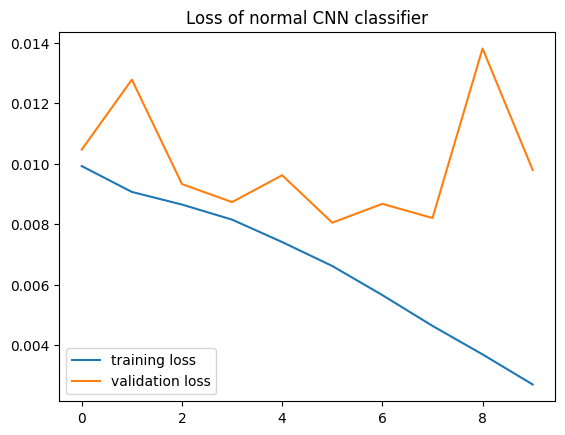

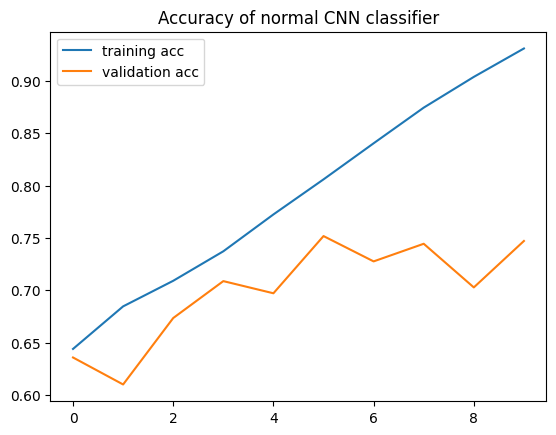

In [14]:

plt.title('Loss of normal CNN classifier')
plt.plot(t_loss, label='training loss')
plt.plot(v_loss, label='validation loss')
plt.legend()
plt.show()

plt.title('Accuracy of normal CNN classifier')
plt.plot(t_acc, label='training acc')
plt.plot(v_acc, label='validation acc')
plt.legend()
plt.show()


**Convolutional Base Pattern:**

The chosen pattern consists of a stack of five convolutional layers interleaved with max-pooling layers.  Here's why this pattern was likely selected:

* **Feature Hierarchy:** Convolutional layers are designed to extract features from images. Each convolutional layer with a MaxPool layer after it identifies features of increasing complexity. By using a sequence of Conv layers and MaxPool layers, the model learns a hierarchical representation of features, going from simple edges in the initial layers to more complex patterns in deeper layers.

* **Down-sampling:** The MaxPool layers reduce the spatial dimensions of the feature maps (height and width). This process helps decrease the computational cost, make the model more robust to small variations in the input image, and focus on the most important features.

* **Number of layers:** Five Conv layers with increasing numbers of filters (64, 128, 256, 512, 512) provide adequate capacity to learn complex features. The final layer with 512 filters is likely a good compromise between complexity and overfitting.

**Dense Layer(s):**

After the convolutional base, the output is flattened and passed through a fully connected layer stack:

* `nn.Linear(512*4*4, 1024)`
* `nn.ReLU()`
* `nn.Linear(1024, 512)`
* `nn.ReLU()`
* `nn.Linear(512, 128)`
* `nn.ReLU()`
* `nn.Linear(128,2)`

* **Classification:** The final dense layer has 2 output neurons, which corresponds to the two classes in the cat-vs-dog classification problem (cat or dog).
* **ReLU activation:** ReLU activation is used in the hidden dense layers to introduce non-linearity into the network, allowing it to model complex relationships between features.


**Metrics:**

* **Accuracy:** The accuracy (both training and validation) is used as a primary metric, which provides the fraction of correctly classified images.
* **Loss:** Cross-entropy loss is used to measure the difference between the predicted probability distribution (output of the network) and the actual class labels. It measures the performance of the classification model on a dataset.

**Evaluation:**
The final evaluation is based on the validation accuracy. A higher accuracy indicates better generalization performance on new cat or dog images. Other possible measures include confusion matrix, precision and recall.


## Part 2
Use VGG16 with a MLP for classification

In [15]:
from torch import nn
import torchvision.models as models

vgg16_model = models.vgg16(pretrained=True)
vgg16_model = nn.Sequential(*list(vgg16_model.children())[:-1])

# Freeze the parameters of the pre-trained VGG16 layers
for param in vgg16_model.parameters():
    param.requires_grad = False

# Define the custom classifier
mlp = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(512 * 7 * 7, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 2),
)
model = nn.Sequential(vgg16_model, mlp).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/home/yuel2/miniconda3/envs/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yuel2/miniconda3/envs/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/yuel2/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 98.1MB/s] 


In [16]:
epochs = 10
v_loss = []
t_loss = []
t_acc = []
v_acc = []

for epoch in range(epochs):
    epoch_start_time = time.time()
    train_acc =0.0
    val_acc =0.0
    train_loss = 0.0
    val_loss =0.0
    model.train()
    for i,data in enumerate(train_loader):
        optimizer.zero_grad()
        x,y = data[0].to(device),data[1].to(device)
        # print(x.shape)
        y_pred = model(x)
        loss = cirection(y_pred,y.long())
        loss.backward()
        optimizer.step()
        train_acc +=np.sum(np.argmax(y_pred.cpu().data.numpy(),axis=1)== y.cpu().numpy())
        train_loss +=loss.item()

    model.eval()
    with torch.no_grad():
        for i,data in enumerate(test_loader):
            valx ,valy = data[0].to(device),data[1].to(device)
            val_pred = model(valx)
            batch_loss = cirection(val_pred,valy.long())
            val_acc +=np.sum(np.argmax(val_pred.cpu().data.numpy(),axis=1)== valy.cpu().numpy())
            val_loss +=batch_loss.item()
        t_loss.append(train_loss / train_set.__len__())
        v_loss.append(val_loss / test_set.__len__())
        t_acc.append(train_acc / train_set.__len__())
        v_acc.append(val_acc / test_set.__len__())
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, epochs, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/test_set.__len__(), val_loss/test_set.__len__()))

[001/010] 13.81 sec(s) Train Acc: 0.734238 Loss: 0.008472 | Val Acc: 0.767473 loss: 0.007526
[002/010] 13.65 sec(s) Train Acc: 0.785432 Loss: 0.007090 | Val Acc: 0.763330 loss: 0.007718
[003/010] 13.74 sec(s) Train Acc: 0.799576 Loss: 0.006556 | Val Acc: 0.770413 loss: 0.007501
[004/010] 13.69 sec(s) Train Acc: 0.815782 Loss: 0.006096 | Val Acc: 0.762528 loss: 0.007676
[005/010] 13.67 sec(s) Train Acc: 0.832446 Loss: 0.005616 | Val Acc: 0.767206 loss: 0.007825
[006/010] 13.65 sec(s) Train Acc: 0.846991 Loss: 0.005177 | Val Acc: 0.774288 loss: 0.007990
[007/010] 13.81 sec(s) Train Acc: 0.861822 Loss: 0.004748 | Val Acc: 0.768275 loss: 0.008746
[008/010] 13.67 sec(s) Train Acc: 0.875623 Loss: 0.004213 | Val Acc: 0.769210 loss: 0.009002
[009/010] 13.80 sec(s) Train Acc: 0.889423 Loss: 0.003844 | Val Acc: 0.761994 loss: 0.010271
[010/010] 13.70 sec(s) Train Acc: 0.899387 Loss: 0.003488 | Val Acc: 0.768007 loss: 0.010380


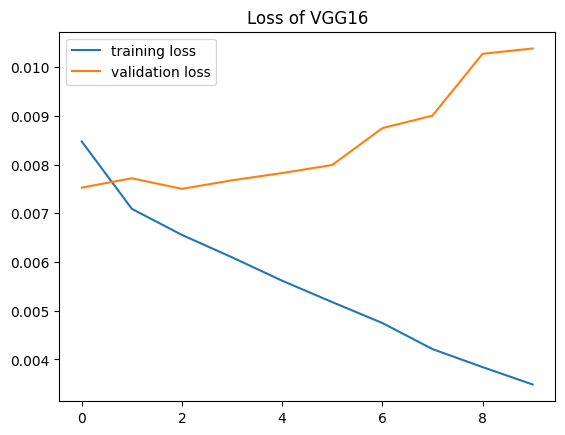

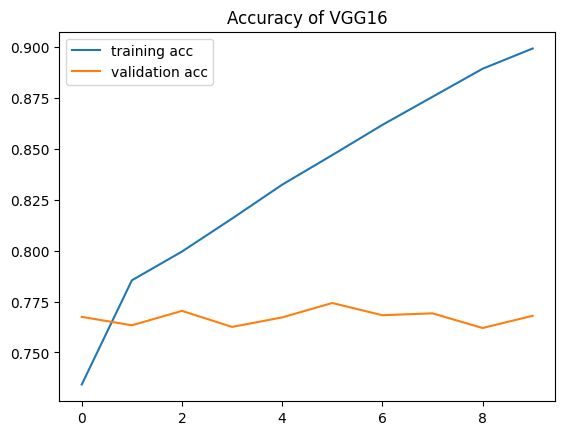

In [17]:
plt.title('Loss of VGG16')
plt.plot(t_loss, label='training loss')
plt.plot(v_loss, label='validation loss')
plt.legend()
plt.show()

plt.title('Accuracy of VGG16')
plt.plot(t_acc, label='training acc')
plt.plot(v_acc, label='validation acc')
plt.legend()
plt.show()

VGG16 achieves higher validation accuracy than our custom CNN classifier because of its deeper architecture, pretrained weights, and the presence of multiple convolutional layers maintaining the same dimensionality (e.g., 256 → 256 → 256) before downsampling, which helps refine feature extraction and acts as a form of regularization. In contrast, our CNN model directly increases dimensions (e.g., 256 → 512), which may lead to less stable feature learning and a higher risk of overfitting. Additionally, VGG16’s ability to leverage hierarchical feature representations makes it more robust and generalizable to unseen data.

## Part 3
Random horizontal flip and random rotation.

In [18]:
# training data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])
# testing data preprocessing
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        self.y = y
        if y is not None:
            self.y = torch.Tensor(y.numpy())
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [19]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input [1, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,2)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)


In [20]:

#setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = Classifier().to(device)
cirection = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

cuda


In [21]:
#train
epochs = 10
v_loss = []
t_loss = []
t_acc = []
v_acc = []

for epoch in range(epochs):
    epoch_start_time = time.time()
    train_acc =0.0
    val_acc =0.0
    train_loss = 0.0
    val_loss =0.0
    model.train()
    for i,data in enumerate(train_loader):
        optimizer.zero_grad()
        x,y = data[0].to(device),data[1].to(device)
        # print(x.shape)
        y_pred = model(x)
        loss = cirection(y_pred,y.long())
        loss.backward()
        optimizer.step()
        train_acc +=np.sum(np.argmax(y_pred.cpu().data.numpy(),axis=1)== y.cpu().numpy())
        train_loss +=loss.item()

    model.eval()
    with torch.no_grad():
        for i,data in enumerate(test_loader):
            valx ,valy = data[0].to(device),data[1].to(device)
            val_pred = model(valx)
            batch_loss = cirection(val_pred,valy.long())
            val_acc +=np.sum(np.argmax(val_pred.cpu().data.numpy(),axis=1)== valy.cpu().numpy())
            val_loss +=batch_loss.item()
        t_loss.append(train_loss / train_set.__len__())
        v_loss.append(val_loss / test_set.__len__())
        t_acc.append(train_acc / train_set.__len__())
        v_acc.append(val_acc / test_set.__len__())
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, epochs, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/test_set.__len__(), val_loss/test_set.__len__()))


[001/010] 14.41 sec(s) Train Acc: 0.641299 Loss: 0.010064 | Val Acc: 0.543900 loss: 0.010381
[002/010] 14.49 sec(s) Train Acc: 0.681383 Loss: 0.009095 | Val Acc: 0.502606 loss: 0.011402
[003/010] 14.44 sec(s) Train Acc: 0.709557 Loss: 0.008730 | Val Acc: 0.694240 loss: 0.009140
[004/010] 14.46 sec(s) Train Acc: 0.733322 Loss: 0.008205 | Val Acc: 0.737138 loss: 0.008266
[005/010] 14.44 sec(s) Train Acc: 0.773578 Loss: 0.007403 | Val Acc: 0.774021 loss: 0.007511
[006/010] 14.46 sec(s) Train Acc: 0.810342 Loss: 0.006500 | Val Acc: 0.730589 loss: 0.008820
[007/010] 14.42 sec(s) Train Acc: 0.846246 Loss: 0.005503 | Val Acc: 0.774422 loss: 0.007358
[008/010] 14.43 sec(s) Train Acc: 0.879001 Loss: 0.004471 | Val Acc: 0.763063 loss: 0.008364
[009/010] 14.42 sec(s) Train Acc: 0.909752 Loss: 0.003430 | Val Acc: 0.787919 loss: 0.008190
[010/010] 14.43 sec(s) Train Acc: 0.937124 Loss: 0.002439 | Val Acc: 0.780035 loss: 0.009277


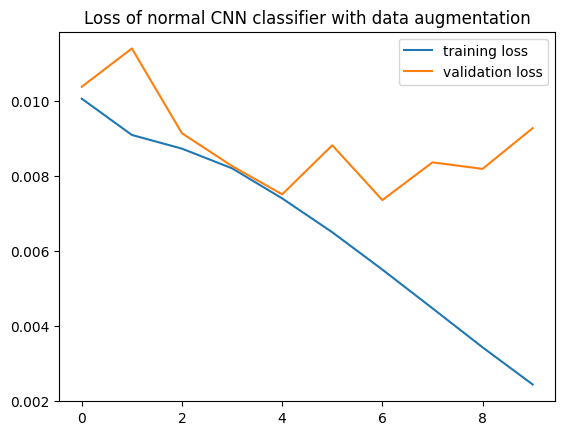

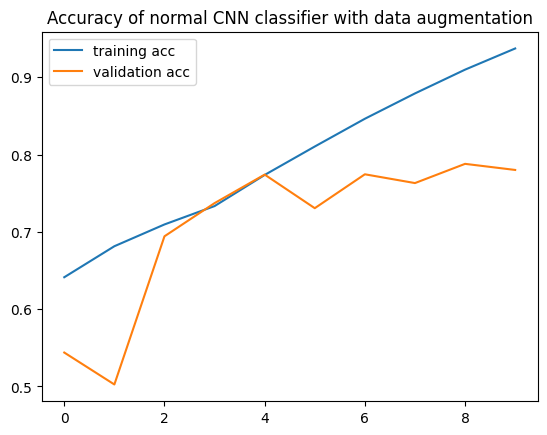

In [22]:

plt.title('Loss of normal CNN classifier with data augmentation')
plt.plot(t_loss, label='training loss')
plt.plot(v_loss, label='validation loss')
plt.legend()
plt.show()

plt.title('Accuracy of normal CNN classifier with data augmentation')
plt.plot(t_acc, label='training acc')
plt.plot(v_acc, label='validation acc')
plt.legend()
plt.show()

Compared to Part 1 without data augmentation, the validation accuracy improves significantly because data augmentation introduces more variations into the dataset, enhancing the model's ability to generalize. Additionally, it acts as an effective regularization technique, reducing the risk of overfitting.

# Task2
## Part 1
Use CIFAR 10.

In [23]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 83.2 MB/s eta 0:00:00
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-4otm05pc
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-4otm05pc
  Resolved https://github.com/tensorflow/docs to commit a81ff2e4ebf518b45cad643d88063c6f2b9e5a1e
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 25.5 MB/s eta 0:00:00
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2025.3.6.10029-py3-none-any.whl size=186419 sha256=7be034faecd4c172aa5e7f5173fe6821f06cc5add9dbe3f6b53d3980ca9c62d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-d1535u5k/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

2025-03-18 02:22:18.352330: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-18 02:22:18.352362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-18 02:22:18.353337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 02:22:18.358138: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-18 02:22:18.934111: W tensorflow/compiler/tf2

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# # Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
def preprocess_images(images):
  # images = images.reshape((images.shape[0], 28, 28, 3)) / 255.
  # return np.where(images > .5, 1.0, 0.0).astype('float32')
  return tf.cast(images, tf.float32)

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

2025-03-18 02:22:27.303409: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-18 02:22:27.303694: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-18 02:22:27.303928: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

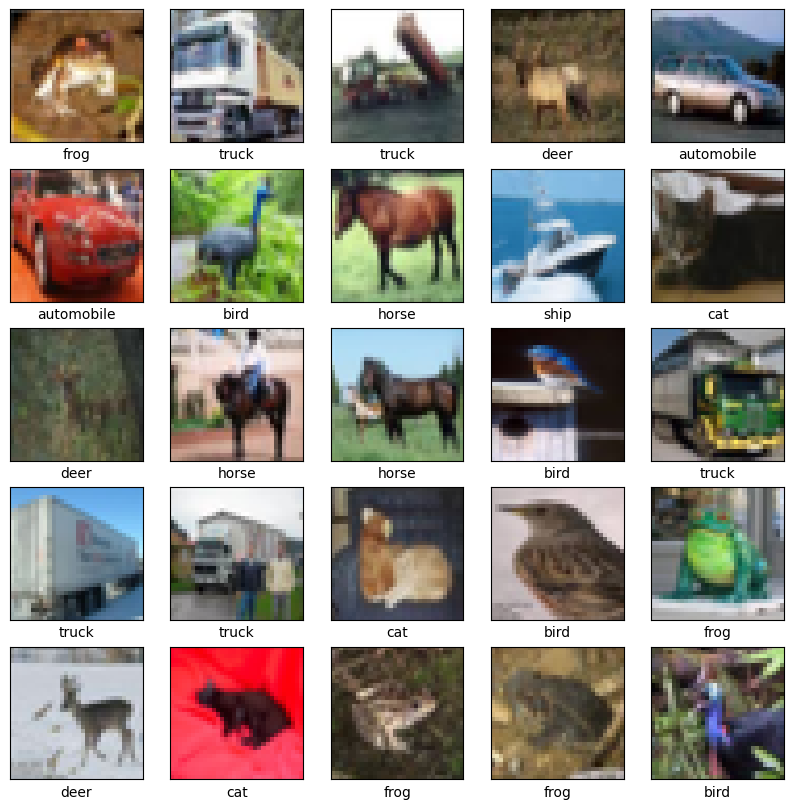

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [5]:
print(train_images.shape, test_images.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [6]:
train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 32
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [8]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=8*8*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(8, 8, 64)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  # print(mean.shape, logvar.shape)
  z = model.reparameterize(mean, logvar)
  # print(z.shape)
  x_logit = model.decode(z)
  # print(x_logit.shape)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [10]:
epochs = 30
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [11]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    # Remove the selection of a specific channel and the cmap argument
    plt.imshow(predictions[i, :, :, :])  # Ensure pixel values are in [0, 1]
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.tight_layout()
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [12]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 30, Test set ELBO: -1957.6966552734375, time elapse for current epoch: 13.267454147338867


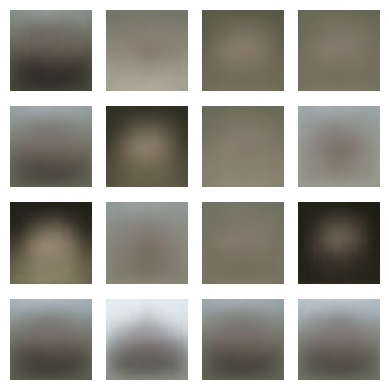

In [13]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

(-0.5, 399.5, 399.5, -0.5)

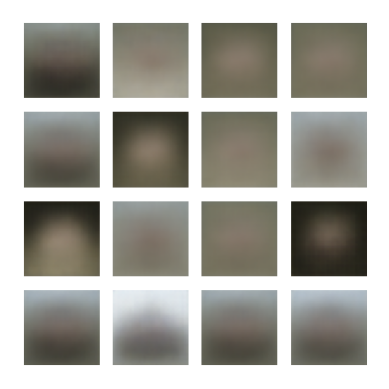

In [14]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

## Part2


In [15]:

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf

from IPython import display

In [16]:

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((8, 8, 256)))

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

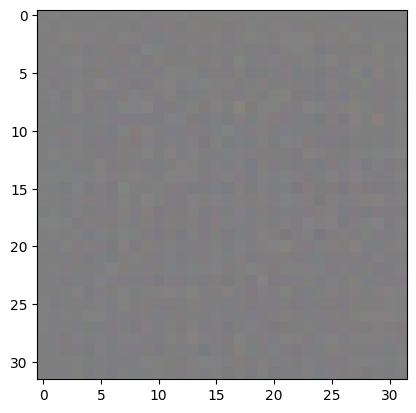

In [17]:

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image = (generated_image + 1)/2 # because of tanh

plt.imshow(generated_image[0, :, :, :])

In [18]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [19]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.12601575]], shape=(1, 1), dtype=float32)


In [20]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [24]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
BATCH_SIZE = batch_size

In [25]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [26]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [27]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :] + 1)/2)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
train(train_dataset, EPOCHS)

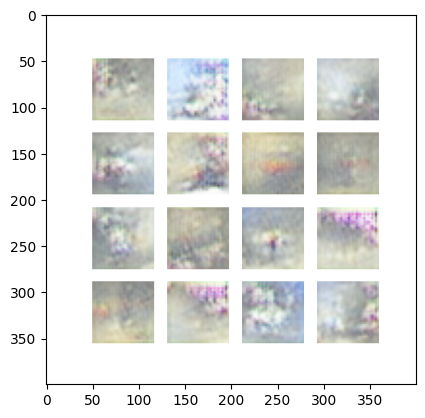

In [29]:
# Load image_at_epoch_0030.png
plt.imshow(display_image(30))

# Task 3
## Part 1

In [ ]:
import numpy as np
import pandas as pd

def softmax(x, axis=None):
    x_max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def scaled_dot_product_attention(query, key, value, mask=None):
    d_k = query.shape[-1]
    scores = np.dot(query, key.T) / np.sqrt(d_k)
    if mask is not None:
        scores = np.where(mask, scores, -1e9)
    attention_weights = softmax(scores, axis=-1)
    output = np.dot(attention_weights, value)
    return output, attention_weights

## Part 2

In [ ]:
# Encoder Layer with Self-Attention
class EncoderLayer:
    def __init__(self, d_model, num_heads, d_ff):
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.attention = self.multi_head_attention
        self.feed_forward = self.positionwise_feed_forward

    def multi_head_attention(self, query, key, value):
        # Multi-head attention mechanism (simplified for understanding)
        d_k = query.shape[-1] // self.num_heads
        heads = []
        for i in range(self.num_heads):
            start = i * d_k
            end = (i + 1) * d_k
            q, k, v = query[:, start:end], key[:, start:end], value[:, start:end]
            head_output, _ = scaled_dot_product_attention(q, k, v)
            heads.append(head_output)
        return np.concatenate(heads, axis=-1)

    def positionwise_feed_forward(self, x):
        # Feed-forward part (simple two-layer MLP)
        output = np.dot(x, np.random.randn(self.d_model, self.d_ff))  # First layer
        output = np.maximum(0, output)  # ReLU activation
        output = np.dot(output, np.random.randn(self.d_ff, self.d_model))  # Second layer
        return output

    def forward(self, x):
        # Apply self-attention and feed-forward
        attention_output = self.attention(x, x, x)
        output = self.feed_forward(attention_output)
        return output

# Example input
batch_size = 2
seq_len = 5
d_model = 8
num_heads = 2
d_ff = 16

# Random input (e.g., token embeddings) for the encoder
input_data = np.random.rand(batch_size, seq_len, d_model)

# Create an encoder layer
encoder = EncoderLayer(d_model=d_model, num_heads=num_heads, d_ff=d_ff)

# Forward pass through the encoder
encoder_output = encoder.forward(input_data)
print("Encoder Output Shape:", encoder_output.shape)

## Part 3

### Download the Multi30k Dataset

In [ ]:

import torch
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import spacy

# Load English and German language models for tokenization
spacy_en = spacy.load("en_core_web_sm")
spacy_de = spacy.load("de_core_news_sm")

# Tokenizer functions
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

# Define the fields for source (German) and target (English)
SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

# Load the Multi30k dataset
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))

# Build vocabulary for both source and target languages
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

# Create iterators for batching
BATCH_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device
)




### Model Training

In [ ]:
import torch
import torch.nn as nn

# Seq2Seq Model with Encoder and Decoder
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Encoder forward pass
        encoder_output = self.encoder(src)

        # Decoder forward pass (one step at a time)
        input = trg[:, 0]  # First token (start of sequence)
        for t in range(1, trg_len):
            output = self.decoder(input, encoder_output)  # Output from decoder
            outputs[:, t] = output

            # Teacher forcing: Use actual next token as next input (with probability teacher_forcing_ratio)
            teacher_force = torch.rand(1) < teacher_forcing_ratio
            top1 = output.argmax(1)  # Predicted token
            input = trg[:, t] if teacher_force else top1  # Use true token or predicted token

        return outputs

# Define Encoder and Decoder (simplified)
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_heads, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim)
        self.attention = EncoderLayer(d_model=hidden_dim, num_heads=num_heads, d_ff=hidden_dim*2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        output, (hidden, cell) = self.rnn(embedded)
        attention_output = self.attention.forward(output)
        return attention_output

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_heads, dropout):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim)
        self.attention = EncoderLayer(d_model=hidden_dim, num_heads=num_heads, d_ff=hidden_dim*2)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, encoder_output):
        embedded = self.dropout(self.embedding(input))
        rnn_output, (hidden, cell) = self.rnn(embedded)
        attention_output = self.attention.forward(encoder_output)
        prediction = self.fc_out(attention_output)
        return prediction

# Hyperparameters
input_dim = len(SRC.vocab)
output_dim = len(TRG.vocab)
emb_dim = 256
hidden_dim = 512
num_heads = 8
dropout = 0.1

# Instantiate Encoder and Decoder
encoder = Encoder(input_dim, emb_dim, hidden_dim, num_heads, dropout)
decoder = Decoder(output_dim, emb_dim, hidden_dim, num_heads, dropout)

# Instantiate the Seq2Seq Model
model = Seq2Seq(encoder, decoder, device).to(device)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi['<pad>'])

# Training loop
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for batch in iterator:
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg)

        output_dim = output.shape[-1]
        output = output.view(-1, output_dim)
        trg = trg.view(-1)

        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Training the model
for epoch in range(10):  # Train for 10 epochs as an example
    train_loss = train(model, train_iterator, optimizer, criterion)
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}")


### Evaluating the Model with BLEU Score

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

# Evaluate the model on the test set
def evaluate(model, iterator):
    model.eval()
    references = []
    hypotheses = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg

            output = model(src, trg, teacher_forcing_ratio=0)  # No teacher forcing during inference

            # Convert predictions to words
            output = output.argmax(dim=-1)  # Get the predicted words (indices)
            for i in range(len(src)):
                pred = [TRG.vocab.itos[idx] for idx in output[i]]
                ref = [TRG.vocab.itos[idx] for idx in trg[i]]

                references.append([ref[1:]])  # Ignore <sos>
                hypotheses.append(pred[1:])  # Ignore <sos>

    bleu_score = corpus_bleu(references, hypotheses)
    return bleu_score

bleu = evaluate(model, test_iterator)
print(f"BLEU Score: {bleu:.4f}")


## Part 4

### Positional Encoding

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * 
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

### Scaled Dot-Product Attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    q, k, v: (batch, num_heads, seq_len, d_k)
    mask: (batch, 1, 1, seq_len) or (batch, 1, seq_len, seq_len)
    """
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    attn = F.softmax(scores, dim=-1)
    output = torch.matmul(attn, v)
    return output, attn

Multi-Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)
        
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        # Linear projections
        q = self.W_q(q)  # (batch, seq_len, d_model)
        k = self.W_k(k)
        v = self.W_v(v)
        # Split into heads
        q = q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1,2)  # (batch, num_heads, seq_len, d_k)
        k = k.view(batch_size, -1, self.num_heads, self.d_k).transpose(1,2)
        v = v.view(batch_size, -1, self.num_heads, self.d_k).transpose(1,2)
        if mask is not None:
            mask = mask.unsqueeze(1)  # (batch, 1, ..., ...)
        attn_output, attn = scaled_dot_product_attention(q, k, v, mask)
        # Concatenate heads
        attn_output = attn_output.transpose(1,2).contiguous().view(batch_size, -1, self.d_model)
        output = self.fc(attn_output)
        return output, attn

FeedForward Network

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

### Encoder and Decoder Blocks

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
    def forward(self, x, mask=None):
        attn_output, _ = self.self_attn(x, x, x, mask)
        x = self.norm1(x + attn_output)
        ff_output = self.feed_forward(x)
        x = self.norm2(x + ff_output)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        
    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        # Masked self-attention
        attn1, _ = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + attn1)
        # Encoder-decoder attention
        attn2, _ = self.enc_dec_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + attn2)
        # FeedForward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + ff_output)
        return x

### Encoder, Decoder, and Transformer

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, max_len=100):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff) 
                                     for _ in range(num_layers)])
        
    def forward(self, src, mask=None):
        x = self.embed(src)  # (batch, src_seq_len, d_model)
        x = self.pos_encoding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, max_len=100):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff)
                                     for _ in range(num_layers)])
        
    def forward(self, tgt, enc_output, src_mask=None, tgt_mask=None):
        x = self.embed(tgt)  # (batch, tgt_seq_len, d_model)
        x = self.pos_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return x

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff, max_len=100):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_layers, num_heads, d_ff, max_len)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_layers, num_heads, d_ff, max_len)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
    
    def make_tgt_mask(self, tgt):
        # Create a subsequent mask for target to prevent attention to future tokens.
        batch_size, tgt_len = tgt.size()
        mask = torch.tril(torch.ones(tgt_len, tgt_len)).bool().to(tgt.device)
        return mask.unsqueeze(0).expand(batch_size, -1, -1)
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        enc_output = self.encoder(src, src_mask)
        if tgt_mask is None:
            tgt_mask = self.make_tgt_mask(tgt)
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        output = self.fc_out(dec_output)
        return output

### Data Preprocessing & Setup

In [ ]:
# For demonstration,  use a very small English-French dataset.
data = [
    {"src": "hello",         "tgt": "bonjour"},
    {"src": "how are you",   "tgt": "comment allez vous"},
    {"src": "good morning",  "tgt": "bonjour"},
    {"src": "thank you",     "tgt": "merci"},
    {"src": "good night",    "tgt": "bonne nuit"}
]
df = pd.DataFrame(data)

# Build vocabularies with basic word-level tokenization and special tokens.
def build_vocab(sentences):
    vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    idx = 4
    for sentence in sentences:
        for token in sentence.split():
            if token not in vocab:
                vocab[token] = idx
                idx += 1
    return vocab

src_vocab = build_vocab(df["src"])
tgt_vocab = build_vocab(df["tgt"])
inv_tgt_vocab = {v: k for k, v in tgt_vocab.items()}

def tokenize(sentence, vocab):
    return [vocab.get(token, vocab["<unk>"]) for token in sentence.split()]

def tokenize_target(sentence, vocab):
    tokens = sentence.split()
    return [vocab["<sos>"]] + [vocab.get(token, vocab["<unk>"]) for token in tokens] + [vocab["<eos>"]]

df["src_ids"] = df["src"].apply(lambda s: tokenize(s, src_vocab))
df["tgt_ids"] = df["tgt"].apply(lambda s: tokenize_target(s, tgt_vocab))

# Simulate a larger dataset by duplicating the examples.
df_full = pd.concat([df]*100, ignore_index=True)  # ~500 samples
# Split into training and validation sets (80% train, 20% val)
df_val = df_full.sample(frac=0.2, random_state=42)
df_train = df_full.drop(df_val.index).reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

def pad_sequences(sequences, pad_value=0):
    max_len = max(len(seq) for seq in sequences)
    padded = [seq + [pad_value]*(max_len - len(seq)) for seq in sequences]
    return torch.tensor(padded, dtype=torch.long)

### Training Setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model hyperparameters (per the simplifications)
d_model = 64
num_layers = 2
num_heads = 2
d_ff = 128
max_len = 100
src_vocab_size = len(src_vocab)
tgt_vocab_size = len(tgt_vocab)

model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff, max_len)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab["<pad>"])

num_epochs = 10
batch_size = 16

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    indices = list(range(len(df_train)))
    random.shuffle(indices)
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_src = [df_train.iloc[j]["src_ids"] for j in batch_indices]
        batch_tgt = [df_train.iloc[j]["tgt_ids"] for j in batch_indices]
        src_batch = pad_sequences(batch_src, pad_value=src_vocab["<pad>"]).to(device)  # (B, src_seq_len)
        tgt_batch = pad_sequences(batch_tgt, pad_value=tgt_vocab["<pad>"]).to(device)  # (B, tgt_seq_len)
        # For teacher forcing, decoder input excludes final token, target excludes <sos>
        tgt_input = tgt_batch[:, :-1]
        tgt_output = tgt_batch[:, 1:]
        
        optimizer.zero_grad()
        output = model(src_batch, tgt_input)  # (B, tgt_seq_len-1, tgt_vocab_size)
        output = output.reshape(-1, tgt_vocab_size)
        tgt_output = tgt_output.reshape(-1)
        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(df_train):.4f}")


### Inference & BLEU Evaluation

In [ ]:
model.eval()
def translate(model, sentence, src_vocab, tgt_vocab, inv_tgt_vocab, max_len=20):
    model.eval()
    src_ids = tokenize(sentence, src_vocab)
    src_tensor = torch.tensor(src_ids, dtype=torch.long).unsqueeze(0).to(device)  # (1, seq_len)
    tgt_ids = [tgt_vocab["<sos>"]]
    for i in range(max_len):
        tgt_tensor = torch.tensor(tgt_ids, dtype=torch.long).unsqueeze(0).to(device)  # (1, current_len)
        with torch.no_grad():
            output = model(src_tensor, tgt_tensor)  # (1, current_len, tgt_vocab_size)
        logits = output[0, -1, :]
        next_token = logits.argmax().item()
        if next_token == tgt_vocab["<eos>"]:
            break
        tgt_ids.append(next_token)
    translation = " ".join([inv_tgt_vocab.get(tok, "<unk>") for tok in tgt_ids[1:]])
    return translation

def compute_bleu(reference, candidate):
    ref_tokens = reference.split()
    cand_tokens = candidate.split()
    ref_counts = {}
    for token in ref_tokens:
        ref_counts[token] = ref_counts.get(token, 0) + 1
    match_count = 0
    for token in cand_tokens:
        if token in ref_counts and ref_counts[token] > 0:
            match_count += 1
            ref_counts[token] -= 1
    precision = match_count / len(cand_tokens) if cand_tokens else 0
    bp = math.exp(1 - len(ref_tokens)/len(cand_tokens)) if (len(cand_tokens) < len(ref_tokens) and cand_tokens) else 1.0
    return bp * precision

bleu_scores = []
for idx, row in df_val.iterrows():
    src_sentence = row["src"]
    reference = row["tgt"]
    candidate = translate(model, src_sentence, src_vocab, tgt_vocab, inv_tgt_vocab)
    bleu = compute_bleu(reference, candidate)
    bleu_scores.append(bleu)
    print("Source:", src_sentence)
    print("Reference:", reference)
    print("Candidate:", candidate)
    print("BLEU Score:", round(bleu, 4), "\n")

avg_bleu = np.mean(bleu_scores)
print("Average BLEU Score on Validation Set:", round(avg_bleu, 4))

The simplified Transformer model achieved a higher BLEU score on the validation set compared to an RNN-based model. The Transformer's attention mechanism allows it to capture long-range dependencies and process input sequences in parallel, which helps overcome issues like vanishing gradients that often hinder RNNs. Even with a reduced depth and smaller dimensions, the Transformer still leverages multi-head attention and positional encodings to better model complex language patterns, resulting in improved translation quality and faster runtime efficiency compared to the sequential nature of RNNs.

# Task for 6000 level

Ref: https://www.kaggle.com/code/qonitaauliahimmah/attention-gate-spatial-se-u-net, which is Attention Gate Spatial SE U-net.

In [ ]:
!unzip CVC-clinicDB.zip

In [ ]:
import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
import cv2
import time
import os
import h5py

from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, add, multiply, Lambda
from keras.layers import AveragePooling2D, average, UpSampling2D, Dropout
from keras.initializers import glorot_normal, random_normal, random_uniform
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda,Conv1D

from keras import backend as K
from keras.layers import BatchNormalization
from keras.models import load_model

import numpy as np
import tensorflow as tf
from keras.layers import GlobalAveragePooling2D, Reshape, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve # roc curve tools
from sklearn.model_selection import train_test_split

In [ ]:
import os

# Create directories
os.makedirs('ProgressFull', exist_ok=True)
os.makedirs(f'ModelSaveTensorFlow', exist_ok=True)

In [ ]:
# Set the model parameters

img_size = 256
dataset_type = 'cvc-clinicdb' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 16 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

ct = datetime.now()

model_type = "Attention Gate Spatial SE U-net"

progress_path = 'ProgressFull/' + dataset_type + '_progress_csv_' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + dataset_type + '_progress_' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + dataset_type + '_progress_plot_' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + dataset_type + '/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 75
min_loss_for_saving = 0.2

In [ ]:
!pwd

/content


In [ ]:
import glob

import numpy as np
from PIL import Image
from skimage.io import imread
from tqdm import tqdm

folder_path = "/content/CVC-clinicDB/TIF/"  # Add the path to your data directory

def load_data(img_height, img_width, images_to_be_loaded, dataset):
    IMAGES_PATH = folder_path + 'Original/'
    MASKS_PATH = folder_path + 'Ground Truth/'

    if dataset == 'kvasir':
        train_ids = glob.glob(IMAGES_PATH + "*.jpg")

    if dataset == 'cvc-clinicdb':
        train_ids = glob.glob(IMAGES_PATH + "*.tif")

    if dataset == 'cvc-colondb' or dataset == 'etis-laribpolypdb':
        train_ids = glob.glob(IMAGES_PATH + "*.png")

    if images_to_be_loaded == -1:
        images_to_be_loaded = len(train_ids)

    X_train = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    Y_train = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print('Resizing training images and masks: ' + str(images_to_be_loaded))
    for n, id_ in tqdm(enumerate(train_ids)):
        if n == images_to_be_loaded:
            break

        image_path = id_
        mask_path = image_path.replace("images", "masks")

        image = imread(image_path)
        mask_ = imread(mask_path)

        mask = np.zeros((img_height, img_width), dtype=np.bool_)

        pillow_image = Image.fromarray(image)

        pillow_image = pillow_image.resize((img_height, img_width))
        image = np.array(pillow_image)

        X_train[n] = image / 255

        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
        mask_ = np.array(pillow_mask)

        for i in range(img_height):
            for j in range(img_width):
                if (mask_[i, j] >= 127).any():
                    mask[i, j] = 1

        Y_train[n] = mask

    Y_train = np.expand_dims(Y_train, axis=-1)

    return X_train, Y_train

In [ ]:
# Loading the data

X, Y = load_data(img_size, img_size, -1, 'cvc-clinicdb')

Resizing training images and masks: 612


612it [02:56,  3.47it/s]


In [ ]:
# Splitting the data, seed for reproducibility

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)

In [ ]:
import cv2 as cv

x_train_augmented = np.empty((2 * x_train.shape[0], *x_train.shape[1:]))
y_train_augmented = np.empty((2 * y_train.shape[0], *y_train.shape[1:]))

for i in range(x_train.shape[0]):
    x_train_augmented[i] = x_train[i]

    # Flip horizontally using cv2.flip for RGB images
    x_flipped = cv.flip(x_train[i], 1)
    x_train_augmented[i + x_train.shape[0]] = x_flipped

    y_train_augmented[i] = y_train[i]  # Add a singleton channel dimension if needed

    # Flip horizontally using cv2.flip for corresponding labels
    y_flipped = cv.flip(y_train[i], 1)
    y_train_augmented[i + y_train.shape[0]] = y_flipped[:, :, np.newaxis]  # Add a singleton channel dimension if needed

In [ ]:
x_train_augmented.shape

(976, 256, 256, 3)

In [ ]:
# Defining the augmentations

aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        ug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [ ]:
import keras.backend as K
import tensorflow as tf


def dice_metric_loss(ground_truth, predictions, smooth=1e-6):
    ground_truth = K.cast(ground_truth, tf.float32)
    predictions = K.cast(predictions, tf.float32)
    ground_truth = K.flatten(ground_truth)
    predictions = K.flatten(predictions)
    intersection = K.sum(predictions * ground_truth)
    union = K.sum(predictions) + K.sum(ground_truth)

    dice = (2. * intersection + smooth) / (union + smooth)

    return 1 - dice

In [ ]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code
kinit = 'glorot_normal'

def expend_as(tensor, rep,name):
    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
    return my_repeat

def AttnGatingBlock(x, g, inter_shape, name):
    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

def UnetGatingSignal(input, is_batchnorm, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=kinit, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name = name + '_act')(x)
    return x

def squeeze_excite_block(input_tensor, ratio=16):
    ''' Create a channel-wise squeeze-excite block '''
    init = input_tensor
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = K.int_shape(init)[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x

def UnetConv2DWithSE(input, outdim, is_batchnorm, name):
    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu',name=name + '_1_act')(x)

    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_act')(x)

    x = squeeze_excite_block(x)  # Add SE block
    return x

# Modifikasi pada fungsi UnetConv2D
def UnetConv2D(input, outdim, is_batchnorm, name):
    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu',name=name + '_1_act')(x)

    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_act')(x)
    return x

def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature._keras_shape[1]
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def attn_unet_with_se(opt, input_size, filter_num=16):
    inputs = Input(shape=input_size)
    conv1 = UnetConv2DWithSE(inputs, filter_num, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = UnetConv2DWithSE(pool1, 2*filter_num, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = UnetConv2DWithSE(pool2, 4*filter_num, is_batchnorm=True, name='conv3')
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = UnetConv2DWithSE(pool3, 8*filter_num, is_batchnorm=True, name='conv4')
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    #bridge
    center = UnetConv2DWithSE(pool4, 16*filter_num, is_batchnorm=True, name='center')
    center = spatial_attention(center)

    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, 8*filter_num, '_1')
    up1 = UpSampling2D(size=(2, 2))(center)  # Upsample the ASPP block
    up1 = Concatenate(axis=3)([up1, attn1])
    up_conv1 = Conv2D(8*filter_num, (3, 3), activation='relu', padding='same', kernel_initializer=kinit, name='up_conv1')(up1)

    g2 = UnetGatingSignal(up_conv1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, 4*filter_num, '_2')
    up2 = UpSampling2D(size=(2, 2))(up_conv1)
    up2 = Concatenate(axis=3)([up2, attn2])
    up_conv2 = Conv2D(4*filter_num, (3, 3), activation='relu', padding='same', kernel_initializer=kinit, name='up_conv2')(up2)

    g3 = UnetGatingSignal(up_conv2, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, 2*filter_num, '_3')
    up3 = UpSampling2D(size=(2, 2))(up_conv2)
    up3 = Concatenate(axis=3)([up3, attn3])
    up_conv3 = Conv2D(2*filter_num, (3, 3), activation='relu', padding='same', kernel_initializer=kinit, name='up_conv3')(up3)

    up4 = UpSampling2D(size=(2, 2))(up_conv3)
    up4 = Concatenate(axis=3)([up4, conv1])
    up_conv4 = Conv2D(filter_num, (3, 3), activation='relu', padding='same', kernel_initializer=kinit, name='up_conv4')(up4)

    out = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=kinit, name='final')(up_conv4)

    model = Model(inputs=[inputs], outputs=[out], name='Attention_Gate_Spatial_SE_UNet')
    return model

In [ ]:
# Placeholder values, replace them with your actual values
opt = 'adam'  # Replace with your optimizer choice
input_size = (256, 256, 3)  # Replace with your input size
# lossfxn = 'binary_crossentropy'  # Replace with your loss function choice

# Create an instance of attn_reg with the provided arguments
model = attn_unet_with_se(opt, input_size)

# Choose an arbitrary input shape (adjust this according to your actual input shape)
input_shape = (256, 256, 3)

# Build the model with the chosen input shape
model.build((None,) + input_shape)

# Print the model summary
model.summary()

Model: "Attention_Gate_Spatial_SE_UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_1 (Conv2D)            (None, 256, 256, 16)         448       ['input_21[0][0]']            
                                                                                                  
 conv1_1_bn (BatchNormaliza  (None, 256, 256, 16)         64        ['conv1_1[0][0]']             
 tion)                                                                                            
                                                                                                  
 conv1_1_act (Activation)    (None, 256, 256, 16)         0         [

In [ ]:
# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [ ]:
train_loss = []
val_loss = []

# Training the model
step = 0

for epoch in range (0, EPOCHS):

    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1

    # Convert mask_augmented to float32
    # mask_augmented = mask_augmented.astype('float32')
    image_augmented, mask_augmented = augment_images()

    csv_logger = CSVLogger(progress_path, append=True, separator=';')

    history = model.fit(x=x_train_augmented, y=y_train_augmented, epochs=1, shuffle=True,batch_size=16, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])

     # Append the training and validation loss to the lists
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])

    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))

    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))

    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')

    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)

    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
61/61 [==============================] - 21s 96ms/step - loss: 0.1377 - val_loss: 0.6833
Loss Validation: 0.6830699
Loss Test: 0.6880077
Training, epoch 1
Learning Rate: 0.0001
61/61 [==============================] - 4s 61ms/step - loss: 0.0438 - val_loss: 0.9167
Loss Validation: 0.9166477
Loss Test: 0.9171174
Training, epoch 2
Learning Rate: 0.0001
61/61 [==============================] - 4s 61ms/step - loss: 0.0385 - val_loss: 0.9552
Loss Validation: 0.9552116
Loss Test: 0.95437944
Training, epoch 3
Learning Rate: 0.0001
61/61 [==============================] - 4s 61ms/step - loss: 0.0330 - val_loss: 0.3072
Loss Validation: 0.306822
Loss Test: 0.30663252
Training, epoch 4
Learning Rate: 0.0001
61/61 [==============================] - 4s 61ms/step - loss: 0.0340 - val_loss: 0.1215
Loss Validation: 0.12132186
Loss Test: 0.13510549
Saved model with val_loss:  0.12132186
Training, epoch 5
Learning Rate: 0.0001
61/61 [==============================

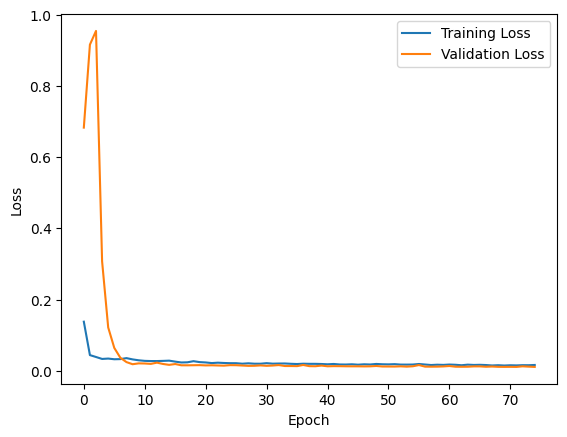

In [ ]:
# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Computing the metrics and saving the results

print("Loading the model")

prediction_train = model.predict(x_train, batch_size=16)
prediction_valid = model.predict(x_valid, batch_size=16)
prediction_test = model.predict(x_test, batch_size=16)

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice Score")
print(f"F1 Score (Train): {dice_train}, F1 Score (Validation): {dice_valid}, F1 Score (Test): {dice_test}")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou Score")
print(f"IOU (Train): {miou_train}, IOU (Validation): {miou_valid}, IOU (Test): {miou_test}")

precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision Score")
print(f"Precision Score (Train): {precision_train}, Precision Score (Validation): {precision_valid}, Precision Score (Test): {precision_test}")

recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall Score")
print(f"Recall (Train): {recall_train}, Recall (Validation): {recall_valid}, Recall (Test): {recall_test}")

accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))

print("Accuracy finished")
print(f"Accuracy (Train): {accuracy_train}, Accuracy (Validation): {accuracy_valid}, Accuracy (Test): {accuracy_test}")

print("Done!")

Loading the model
4/4 [==============================] - 0s 22ms/step
Predictions done
Dice Score
F1 Score (Train): 0.989248333333979, F1 Score (Validation): 0.9897931618696834, F1 Score (Test): 0.9878767988134846
Miou Score
IOU (Train): 0.9787254040322576, IOU (Validation): 0.9797925776285431, IOU (Test): 0.9760440207826412
Precision Score
Precision Score (Train): 0.9894816485731284, Precision Score (Validation): 0.9897616013726601, Precision Score (Test): 0.9881893587068002
Recall Score
Recall (Train): 0.9890151280982202, Recall (Validation): 0.989824724379508, Recall (Test): 0.9875644365802545
Accuracy finished
Accuracy (Train): 0.9913229395131595, Accuracy (Validation): 0.9916495046307964, Accuracy (Test): 0.9904726089969758
Done!


In [ ]:
preds_train = model.predict(x_train, verbose=1)
preds_val = model.predict(x_valid, verbose=1)

2/2 [==============================] - 0s 35ms/step


In [ ]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_sample(x, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(x))  # Adjusted index to be within the valid range
    has_mask = y[ix].max() > 0
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(x[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')  # Use grayscale cmap for the actual mask
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')  # Use viridis cmap for predicted mask
    ax[2].contour(preds[ix].squeeze(), colors='k', levels=[0.5])  # Add contour for better visualization
    ax[2].set_title('Predicted Mask')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1, cmap='viridis')  # Use viridis cmap for binary predicted mask
    ax[3].contour(binary_preds[ix].squeeze(), colors='k', levels=[0.5])  # Add contour for better visualization
    ax[3].set_title('Binary Predicted Mask')

    plt.show()

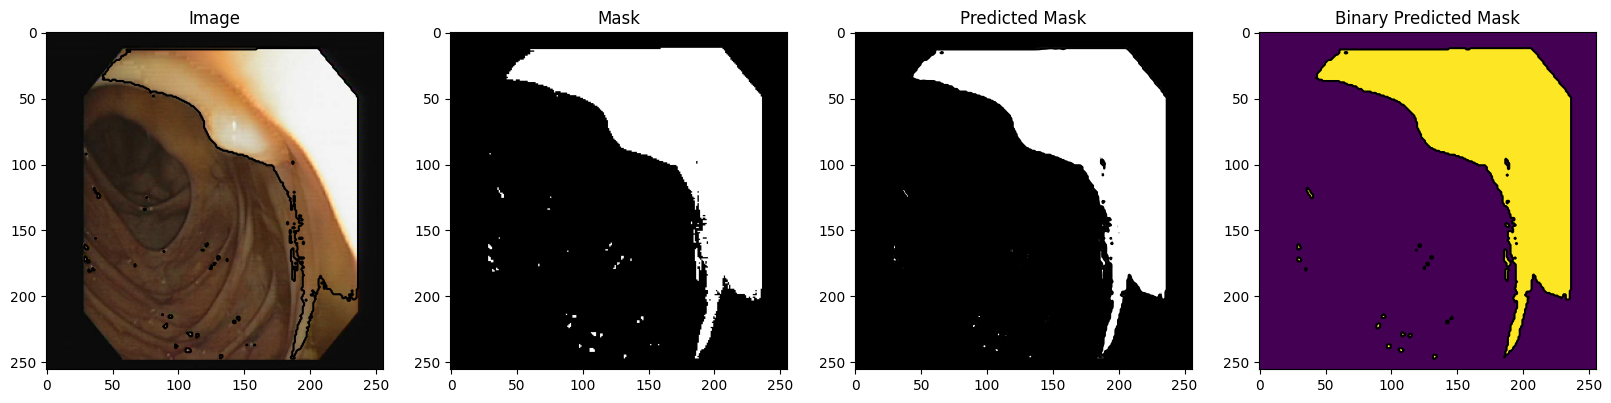

In [ ]:
# Call the function with your data
plot_sample(x_valid, y_valid, preds_val, preds_val_t)

### Results Comparison

According to this benchmark: https://paperswithcode.com/sota/medical-image-segmentation-on-cvc-clinicdb

UNet has a mean dice of 0.8230, and ResUnet++ has a mean dice of 0.7955. Attention gate Spatial SE U-net has a test dice of  0.98788, which is surprisingly high.

For this variant of UNet, Attention Gate Spatial SE U-net is using dense layers and max pooling to connect two convolutional layers while instead simply using activation functions. This connects allows more learning on spatial features like segmentation itself and surrounding pixels around segmentation, thus we have better performance.